In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append('../')
import retrieval_functions as rf

import importlib
importlib.reload(rf)
rf.init_plotting()


In [2]:
experiment="RX_TX"
data=[]
for framework in ["HPMPC"]:
    path= "..\..\..\Ergebnisse\Deviation\\"+framework+"\\"+experiment+"\data\short_results.csv"
    frame=pd.read_csv(path ,header=0,sep=';',index_col=False,engine='python')
    frame['framework']=framework
    if framework=="MPyC":
        # assuming your dataframe is df and the time column is 'time'
        frame['runtime_internal(s)'] = pd.to_datetime(frame['runtime_internal(s)'], format='%H:%M:%S.%f').dt.time
        # convert time to seconds
        frame['runtime_internal(s)'] = frame['runtime_internal(s)'].apply(lambda t: t.hour*3600 + t.minute*60 + t.second + t.microsecond*1e-6)
        frame['peakRAM(MiB)']= frame['peakRAM(MiB)']
    elif framework=="HPMPC":
        factor = 1
        if frame['splitroles'].max() == 1:
            factor = 6	
        elif frame['splitroles'].max() == 2:
            factor = 24
        else:
            factor=1
        frame['runtime_external(s)'] = pd.to_numeric(frame['runtime_external(s)'])* frame['threads'].max()*factor
    data.append(frame)

In [3]:
experiment="000Analysis of Buffer Size"

In [4]:
data[0].columns

Index(['comp.time(s)', 'comp.peakRAM(MiB)', 'bin.filesize(MiB)', 'ssl',
       'threads', 'datatype', 'function', 'optshare', 'packbool', 'protocol',
       'rxbuffer', 'txbuffer', 'latencies(ms)', 'bandwidths(Mbs)',
       'input_size', 'preprocess', 'splitroles', 'packetdrops(%)',
       'verifybuffer', 'inittime(s)', 'preproc(s)', 'runtime_clock(s)',
       'runtime_getTime(s)', 'runtime_chrono(s)', 'runtime_external(s)',
       'peakRAM(MiB)', 'jobCPU(%)', 'framework'],
      dtype='object')

In [5]:
#Latency
latency=[]
label=[]
for function in data[0]['function'].unique():
    for buffer in data[0]['txbuffer'].unique():
                function_filter = data[0]['function'] == function
                buffer_filter = data[0]['txbuffer'] == buffer
                bandwidth_filter = (data[0]['bandwidths(Mbs)'] == 25000) & (data[0]['packetdrops(%)']==0)
                help = data[0].loc[bandwidth_filter & function_filter & buffer_filter & (data[0]['preprocess'] == 0)]
                latency.append(rf.get_mean_std(help,'latencies(ms)')) 
                label.append("HPMPC "+ str(function) +" " +str(buffer))

In [10]:
#Bandwidth
bandwidth=[]
label=[]
for function in data[0]['function'].unique():
    for buffer in data[0]['txbuffer'].unique():
                function_filter = data[0]['function'] == function
                buffer_filter = data[0]['txbuffer'] == buffer
                bandwidth_filter = (data[0]['latencies(ms)'] == 0) & (data[0]['packetdrops(%)']==0)
                help = data[0].loc[bandwidth_filter & function_filter & buffer_filter & (data[0]['preprocess'] == 0)]
                bandwidth.append(rf.get_mean_std(help,'bandwidths(Mbs)')) 
                label.append("HPMPC "+ str(function) +" " +str(buffer))

In [11]:
table_string = "\\begin{center}\n"
table_string += "\\begin{tabular}{|c|c|c|c|c|}\n"
table_string += "\\hline\n"
table_string += "    & "
for band in bandwidth[0].index:
    table_string += "    " + str(band) + " & "
table_string = table_string[:-2] + "\\\\\n"
table_string += "\\hline\n"
for s,band in enumerate(bandwidth):
    table_string += label[s] + " & "
    for i,value in enumerate(band.index):
        table_string += "    " + str(round(band['mean'].iloc[i],3)) + " "+ u"\u00B1" + " " + str(round(band['std'].iloc[i],3))  +  " & "
    table_string = table_string[:-2] + "\\\\\\hline\n"

table_string += "\\end{tabular}\n"
table_string += "\\end{center}"
print(table_string)

\begin{center}
\begin{tabular}{|c|c|c|c|c|}
\hline
    &     100 &     1000 &     10000 &     25000 \\
\hline
HPMPC 49 32 &     0.221 ± 0.065 &     0.138 ± 0.07 &     0.159 ± 0.079 &     0.159 ± 0.05 \\\hline
HPMPC 49 1000 &     0.51 ± 0.107 &     0.157 ± 0.059 &     0.161 ± 0.052 &     0.247 ± 0.14 \\\hline
HPMPC 49 5000 &     0.489 ± 0.09 &     0.185 ± 0.059 &     0.117 ± 0.062 &     0.178 ± 0.101 \\\hline
HPMPC 49 10000 &     0.532 ± 0.028 &     0.238 ± 0.104 &     0.163 ± 0.055 &     0.146 ± 0.054 \\\hline
HPMPC 50 32 &     0.188 ± 0.021 &     0.094 ± 0.039 &     0.101 ± 0.037 &     0.118 ± 0.038 \\\hline
HPMPC 50 1000 &     0.247 ± 0.025 &     0.187 ± 0.023 &     0.148 ± 0.03 &     0.168 ± 0.026 \\\hline
HPMPC 50 5000 &     0.193 ± 0.007 &     0.128 ± 0.009 &     0.126 ± 0.01 &     0.118 ± 0.012 \\\hline
HPMPC 50 10000 &     0.194 ± 0.007 &     0.133 ± 0.009 &     0.118 ± 0.006 &     0.118 ± 0.007 \\\hline
HPMPC 51 32 &     0.17 ± 0.037 &     0.123 ± 0.043 &     0.141 ± 0.051 &   

In [12]:
#Packetdrop
packetdrop=[]
label=[]
for function in data[0]['function'].unique():
    for buffer in data[0]['txbuffer'].unique():
                function_filter = data[0]['function'] == function
                buffer_filter = data[0]['txbuffer'] == buffer
                bandwidth_filter = (data[0]['latencies(ms)'] == 0) & (data[0]['bandwidths(Mbs)']==25000)
                help = data[0].loc[bandwidth_filter & function_filter & buffer_filter & (data[0]['preprocess'] == 0)]
                packetdrop.append(rf.get_mean_std(help,'packetdrops(%)')) 
                label.append("HPMPC "+ str(function) +" " +str(buffer))

In [13]:
table_string = "\\begin{center}\n"
table_string += "\\begin{tabular}{|c|c|c|c|c|}\n"
table_string += "\\hline\n"
table_string += "    & "
for band in packetdrop[0].index:
    table_string += "    " + str(band) + " & "
table_string = table_string[:-2] + "\\\\\n"
table_string += "\\hline\n"
for s,band in enumerate(packetdrop):
    table_string += label[s] + " & "
    for i,value in enumerate(band.index):
        table_string += "    " + str(round(band['mean'].iloc[i],3)) + " "+ u"\u00B1" + " " + str(round(band['std'].iloc[i],3))  +  " & "
    table_string = table_string[:-2] + "\\\\\\hline\n"

table_string += "\\end{tabular}\n"
table_string += "\\end{center}"
print(table_string)

\begin{center}
\begin{tabular}{|c|c|c|c|c|}
\hline
    &     0 &     1 &     2 &     5 \\
\hline
HPMPC 49 32 &     0.159 ± 0.05 &     3.302 ± 0.605 &     6.622 ± 1.088 &     15.841 ± 2.314 \\\hline
HPMPC 49 1000 &     0.247 ± 0.14 &     2.867 ± 0.665 &     6.555 ± 2.229 &     15.592 ± 2.568 \\\hline
HPMPC 49 5000 &     0.178 ± 0.101 &     2.905 ± 1.028 &     5.609 ± 1.031 &     14.473 ± 2.784 \\\hline
HPMPC 49 10000 &     0.146 ± 0.054 &     2.505 ± 0.287 &     6.2 ± 1.402 &     13.567 ± 2.021 \\\hline
HPMPC 50 32 &     0.118 ± 0.038 &     1.293 ± 0.501 &     2.181 ± 1.086 &     5.384 ± 1.414 \\\hline
HPMPC 50 1000 &     0.168 ± 0.026 &     1.055 ± 0.686 &     1.22 ± 0.467 &     5.123 ± 2.111 \\\hline
HPMPC 50 5000 &     0.118 ± 0.012 &     0.997 ± 0.882 &     1.627 ± 0.785 &     3.898 ± 1.07 \\\hline
HPMPC 50 10000 &     0.118 ± 0.007 &     1.253 ± 0.659 &     1.441 ± 0.635 &     3.546 ± 0.459 \\\hline
HPMPC 51 32 &     0.13 ± 0.055 &     0.912 ± 0.483 &     1.708 ± 0.679 &     6.796 

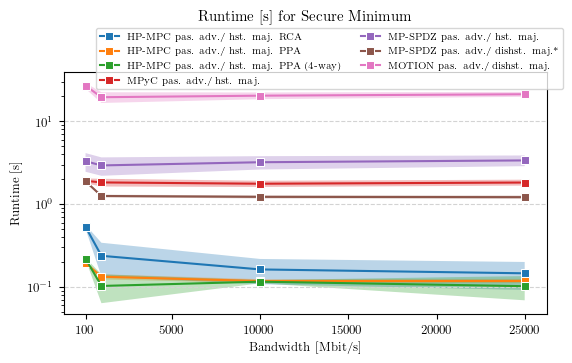

In [69]:
label[0]="HP-MPC pas. adv./ hst. maj. RCA"
label[1]="HP-MPC pas. adv./ hst. maj. PPA"
label[2]="HP-MPC pas. adv./ hst. maj. PPA (4-way)"
label[3]="MPyC pas. adv./ hst. maj."
label[4]="MP-SPDZ pas. adv./ hst. maj."
label[5]="MP-SPDZ pas. adv./ dishst. maj.*"
label[6]="MOTION pas. adv./ dishst. maj."
rf.plot_deviation_bandwidth(bandwidth,label,"Bandwidth_dev.png",experiment,"Bandwidth [Mbit/s]","Runtime [s]",True,x_ticks=[100,5000,10000,15000,20000,25000],right_push=0.55,up_push=1.2)

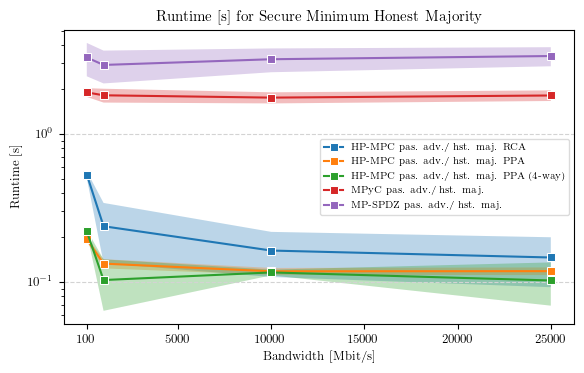

In [70]:
bandwidth_honest = [x for i, x in enumerate(bandwidth) if "dishst." not in label[i]]
label_honest = [x for x in label if "dishst." not in x]
rf.plot_deviation(bandwidth_honest,label_honest,"Bandwidth_dev_honest.png",experiment+" Honest Majority","Bandwidth [Mbit/s]","Runtime [s]",True,x_ticks=[100,5000,10000,15000,20000,25000])

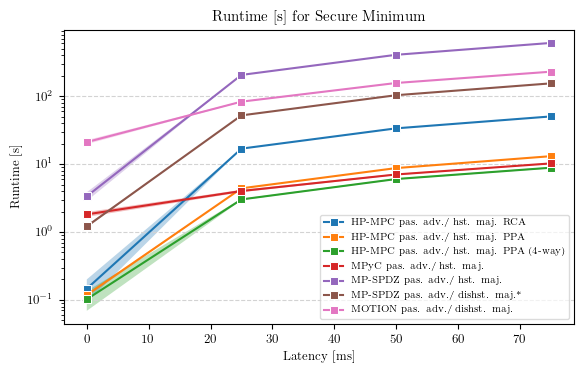

In [72]:
label[0]="HP-MPC pas. adv./ hst. maj. RCA"
label[1]="HP-MPC pas. adv./ hst. maj. PPA"
label[2]="HP-MPC pas. adv./ hst. maj. PPA (4-way)"
label[3]="MPyC pas. adv./ hst. maj."
label[4]="MP-SPDZ pas. adv./ hst. maj."
label[5]="MP-SPDZ pas. adv./ dishst. maj.*"
label[6]="MOTION pas. adv./ dishst. maj."
rf.plot_deviation(latency,label,"Latency_dev.png",experiment,"Latency [ms]","Runtime [s]",True)

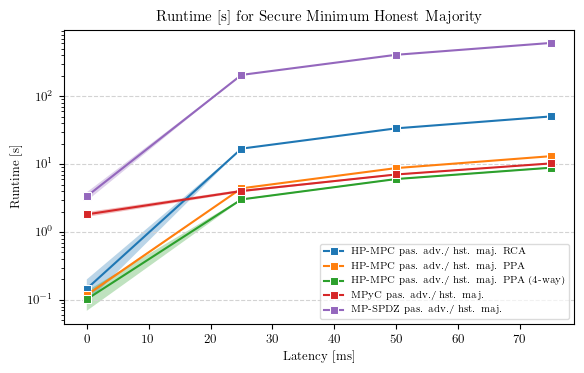

In [73]:
latency_honest = [x for i, x in enumerate(latency) if "dishst." not in label[i]]
label_honest = [x for x in label if "dishst." not in x]
rf.plot_deviation(latency_honest,label_honest,"Latency_dev_honest.png",experiment+" Honest Majority","Latency [ms]","Runtime [s]",True)

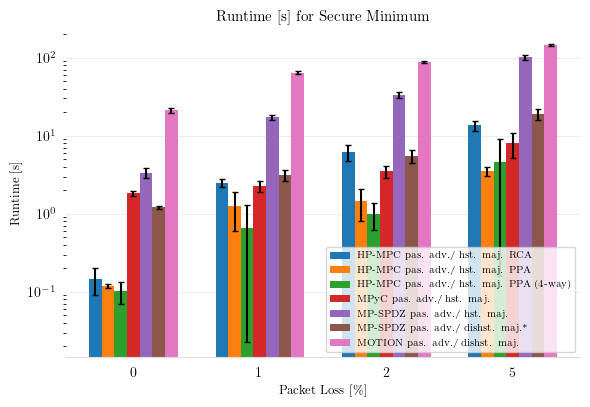

In [74]:
fig, ax = plt.subplots()
width = 0.4 # the width of the bars
ind = np.arange(4)*4  # Adjust the first parameter to center the bars

bar_list=[]
for i in range(len(packetdrop)):
    bar_list.append(ax.bar(ind - 1.2 + i * width, packetdrop[i]['mean'], width, yerr=packetdrop[i]['std'], label=label[i]))

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_yscale('log')
ax.set_ylabel('Runtime [s]')
ax.set_xlabel('Packet Loss [\%]')
ax.set_title('Runtime [s] for Secure Minimum')
ax.set_xticks(ind)
ax.set_xticklabels((packetdrop[0]['packetdrops(%)']))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False,labelsize=10)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
ax.set_axisbelow(True)
ax.set_yscale('log')
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
ax.legend(loc='lower right')
ax.figure.set_size_inches(5.91, 4)
plt.savefig(experiment+'_packetdrop_bar.png',dpi=300, bbox_inches='tight')
plt.show()

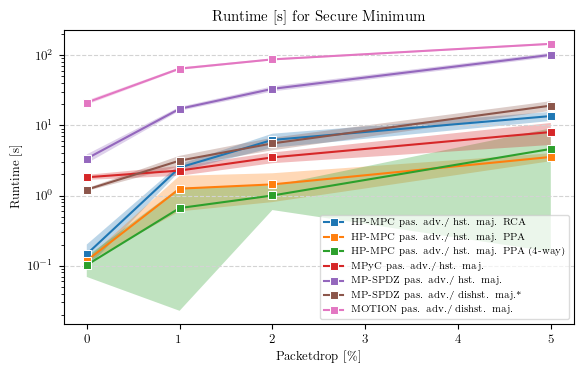

In [75]:
label[0]="HP-MPC pas. adv./ hst. maj. RCA"
label[1]="HP-MPC pas. adv./ hst. maj. PPA"
label[2]="HP-MPC pas. adv./ hst. maj. PPA (4-way)"
label[3]="MPyC pas. adv./ hst. maj."
label[4]="MP-SPDZ pas. adv./ hst. maj."
label[5]="MP-SPDZ pas. adv./ dishst. maj.*"
label[6]="MOTION pas. adv./ dishst. maj."
rf.plot_deviation(packetdrop,label,"Mult_Packetdrop_dev.png",experiment,"Packetdrop [\%]","Runtime [s]",True)

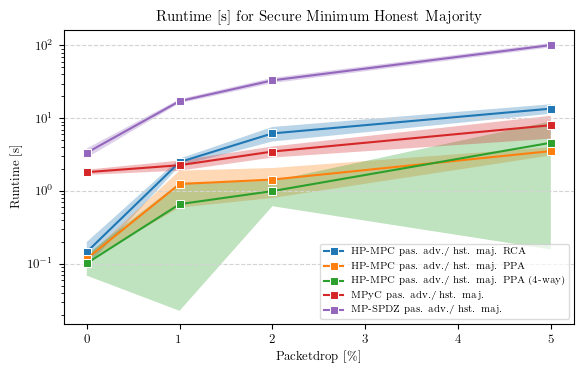

In [38]:
packetdrop_honest = [x for i, x in enumerate(packetdrop) if "dishst." not in label[i]]
label_honest = [x for x in label if "dishst." not in x]
rf.plot_deviation(packetdrop_honest,label_honest,"Mult_Packetdrop_dev_honest.png",experiment+" Honest Majority","Packetdrop [\%]","Runtime [s]",True)

In [76]:
label[0]="HP-MPC \n pas. adv./ hst. maj. RCA"
label[1]="HP-MPC \n pas. adv./ hst. maj. PPA"
label[2]="HP-MPC \n pas. adv./ hst. maj. PPA (4-way)"
label[3]="MPyC \n pas. adv./ hst. maj."
label[4]="MP-SPDZ \n pas. adv./ hst. maj."
label[5]="MP-SPDZ \n pas. adv./ dishst. maj.*"
label[6]="MOTION \n pas. adv./ dishst. maj."

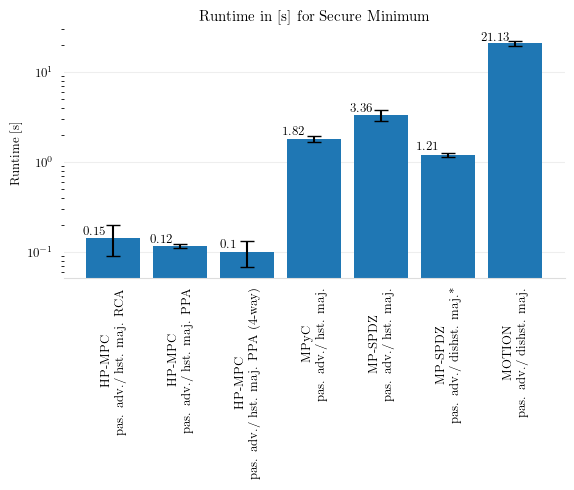

In [79]:
y_label="Runtime [s]"
titel="Runtime in [s] for Secure Minimum"
x_label="Protocols"
mean_values = [round(df['mean'].iloc[0],3) for df in latency]
std_values = [round(df['std'].iloc[0],3) for df in latency]
fig, ax = plt.subplots()
ax.set_yscale('log')  # Set y-axis as logarithmic
bars=ax.bar(label, mean_values,yerr=std_values,capsize=5)
ax.set_ylabel(y_label)
ax.set_title(titel)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Second, remove the ticks as well.
ax.tick_params(bottom=False, left=False)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
# Rotate labels
# Add values on top of bars
for i,bar in enumerate(bars):
    if i in [0,1,2]:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2 - 0.28, yval + 0.003, round(yval,2), ha='center', va='bottom',weight='bold')
    else:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2 - 0.3, yval + 0.1, round(yval,2), ha='center', va='bottom',weight='bold')
ax.figure.set_size_inches(5.9, 3)
plt.xticks(rotation='vertical')
plt.savefig(experiment+'_bar.png',dpi=300, bbox_inches='tight')
plt.show()

C:\Users\q533604\AppData\Local\Temp\ipykernel_13400\1839774764.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  date = float(data[i].loc[(data[i]['function'] == function) & (data[i]['preprocess']==0), ['peakRAM(MiB)']].mean())
C:\Users\q533604\AppData\Local\Temp\ipykernel_13400\1839774764.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  err = float(data[i].loc[(data[i]['function'] == function) & (data[i]['preprocess']==0), ['peakRAM(MiB)']].std())
C:\Users\q533604\AppData\Local\Temp\ipykernel_13400\1839774764.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  date = float(data[i].loc[(data[i]['function'] == function) & (data[i]['preprocess']==0), ['peakRAM(MiB)']].mean())
C:\Users\q5336

[4.1, 4.1, 4.7, 91.32, 11.5, 33.6, 1400.9]


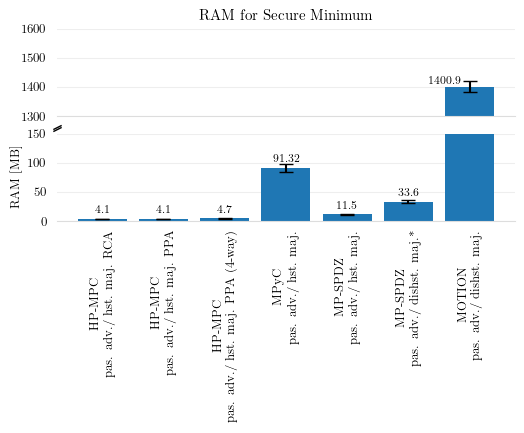

In [62]:
def plot_ram_bar(data,experiment,frameworks):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    values=[]
    label=[]
    error=[]
    for i in range(len(data)):
        if data[i]['framework'][0] == "HPMPC":
            for function in data[i]['function'].unique():
                date = float(data[i].loc[(data[i]['function'] == function) & (data[i]['preprocess']==0), ['peakRAM(MiB)']].mean())
                err = float(data[i].loc[(data[i]['function'] == function) & (data[i]['preprocess']==0), ['peakRAM(MiB)']].std())
                values.append(round(date,1))
                error.append(round(err,1))
                label.append(frameworks[i] + ' honest majority')
        elif data[i]['framework'][0] in ["MP-SPDZ","MOTION"]:
            for protocol in data[i]['protocol'].unique():
                if protocol not in ["ps-rep-field","ps-rep-bin","sy-rep-field","malicious-rep-field"]:
                    date = float(data[i].loc[ (data[i]['protocol']==protocol), ['peakRAM(MiB)']].mean())
                    err = float(data[i].loc[ (data[i]['protocol']==protocol), ['peakRAM(MiB)']].std())
                    values.append(round(date,1))
                    error.append(round(err,1))
                    label.append(frameworks[i]+' '+str(protocol))
        else:
            date = float(data[i]['peakRAM(MiB)'].mean())
            err = float(data[i]['peakRAM(MiB)'].std())
            values.append(round(date,2))
            error.append(round(err,2))
            label.append(frameworks[i])
    
    #ax.set_yscale('log')  # Set y-axis as logarithmic
    print(values)
    label[0]="HP-MPC \n pas. adv./ hst. maj. RCA"
    label[1]="HP-MPC \n pas. adv./ hst. maj. PPA"
    label[2]="HP-MPC \n pas. adv./ hst. maj. PPA (4-way)"
    label[3]="MPyC \n pas. adv./ hst. maj."
    label[4]="MP-SPDZ \n pas. adv./ hst. maj."
    label[5]="MP-SPDZ \n pas. adv./ dishst. maj.*"
    label[6]="MOTION \n pas. adv./ dishst. maj."
    bars=ax1.bar(label,values,yerr=error,capsize=5)
    bars2=ax2.bar(label,values,yerr=error,capsize=5)
    ax2.set_ylabel('RAM [MB]')
    ax1.set_title('RAM for Secure Minimum')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_color('#DDDDDD')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_color('#DDDDDD')

    # Second, remove the ticks as well.
    ax1.tick_params(bottom=False, left=False)
    ax2.tick_params(bottom=False, left=False)
    # Third, add a horizontal grid (but keep the vertical grid hidden).
    # Color the lines a light gray as well.
    ax1.set_axisbelow(True)
    ax1.yaxis.grid(True, color='#EEEEEE')
    ax1.xaxis.grid(False)
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(True, color='#EEEEEE')
    ax2.xaxis.grid(False)
    # Rotate labels
    ax1.set_ylim(1300,1600)
    ax2.set_ylim(0,150)
    # Add values on top of bars
    for bar in bars2[:-1]:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval+6, yval, ha='center', va='bottom',weight='bold',fontsize=8)
    yval = bars[-1].get_height()
    plt.text(bars[-1].get_x() + bars[-1].get_width()/2 - 0.4, yval-1170 + 0.05, yval, ha='center', va='bottom',weight='bold',fontsize=8)

    # zoom-in / limit the view to different portions of the data
    ax1.tick_params(axis='y')
    ax2.tick_params(axis='y')
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=6,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([-0.15], transform=ax1.transAxes, **kwargs)
    ax2.plot([1.08], transform=ax2.transAxes, **kwargs)
    ax1.figure.set_size_inches(5.91, 2.5)
    ax2.figure.set_size_inches(5.91, 2.5)
    plt.xticks(rotation='vertical')
    plt.savefig(experiment+'_RAM_bar.png',dpi=300,bbox_inches='tight')
    plt.show()
plot_ram_bar(data,experiment,["HPMPC","MPyC","MP-SPDZ","MOTION"])